In [1]:
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8,5)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

# sklearn
from sklearn.model_selection import train_test_split, learning_curve, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    roc_auc_score, roc_curve, det_curve, confusion_matrix,
    ConfusionMatrixDisplay, log_loss, matthews_corrcoef, cohen_kappa_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

# tensorflow / keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Dense, Dropout, LSTM, Conv1D, MaxPooling1D, Flatten,
    GRU, Bidirectional, Input, LayerNormalization, MultiHeadAttention,
    GlobalAveragePooling1D, Reshape, Add, BatchNormalization
)
from tensorflow.keras.callbacks import EarlyStopping


In [2]:
def load_file1():
    df = pd.read_csv("file1.csv")
    if "Diagnostic" in df.columns:
        df["Failure"] = (df["Diagnostic"] != "No failure").astype(int)
    df = df.drop(columns=["UDI","Date","Product ID","Diagnostic"], errors="ignore")
    X = df.drop(columns=["Failure"])
    y = df["Failure"]
    return X, y

def make_preprocessor(X_df: pd.DataFrame):
    cat_cols = X_df.select_dtypes(include=["object"]).columns.tolist()
    num_cols = X_df.select_dtypes(include=["int64","float64"]).columns.tolist()
    num_pipe = Pipeline([("imputer", SimpleImputer(strategy="median")),
                         ("scaler", StandardScaler())])
    cat_pipe = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                         ("encoder", OneHotEncoder(handle_unknown="ignore"))])
    return ColumnTransformer([("num", num_pipe, num_cols),
                              ("cat", cat_pipe, cat_cols)])

X, y = load_file1()
preprocessor = make_preprocessor(X)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print("Shapes:", X.shape, y.shape, "| Train/Test:", X_train.shape, X_test.shape)


Shapes: (10000, 8) (10000,) | Train/Test: (8000, 8) (2000, 8)


In [3]:
# Full dataset (for FL partitions + RL risk generation)
X_proc = preprocessor.fit_transform(X)
X_seq  = X_proc.reshape((X_proc.shape[0], X_proc.shape[1], 1))

input_dim   = X_proc.shape[1]
input_shape = X_seq.shape[1:]
y_arr = y.to_numpy() if hasattr(y, "to_numpy") else np.array(y)

# Centralized train/test arrays (for evaluation)
X_train_processed = preprocessor.transform(X_train)
X_test_processed  = preprocessor.transform(X_test)
X_train_seq = X_train_processed.reshape((X_train_processed.shape[0], X_train_processed.shape[1], 1))
X_test_seq  = X_test_processed.reshape((X_test_processed.shape[0],  X_test_processed.shape[1],  1))

print("Processed (full):", X_proc.shape, X_seq.shape, "| (train):", X_train_processed.shape, X_train_seq.shape)


Processed (full): (10000, 12) (10000, 12, 1) | (train): (8000, 12) (8000, 12, 1)


In [4]:
# Simple mode switches
RUN_CENTRALIZED = False     # charts, classical/deep/etc. (Cell 6)
RUN_FL_SIM      = True     # federated learning via simulation (new cell)
RUN_RL          = True     # DQN policy (optional, later cell)
SAVE_WEIGHTS    = True     # set True to save global weights per model & per round

print(f"RUN_CENTRALIZED={RUN_CENTRALIZED}, RUN_FL_SIM={RUN_FL_SIM}, RUN_RL={RUN_RL}, SAVE_WEIGHTS={SAVE_WEIGHTS}")


RUN_CENTRALIZED=False, RUN_FL_SIM=True, RUN_RL=True, SAVE_WEIGHTS=True


In [8]:
# def build_mlp(input_dim):
#     return Sequential([
#         Dense(64, activation='relu', input_shape=(input_dim,)), Dropout(0.3),
#         Dense(32, activation='relu'), Dropout(0.2), Dense(1, activation='sigmoid')
#     ])

def build_lstm(input_shape):
    return Sequential([LSTM(32, input_shape=input_shape), Dropout(0.3), Dense(1, activation='sigmoid')])

def build_cnn1d(input_shape):
    return Sequential([Conv1D(32,3,activation='relu', input_shape=input_shape), MaxPooling1D(2),
                       Flatten(), Dropout(0.3), Dense(1, activation='sigmoid')])

def build_transformer(input_dim):
    inputs = Input(shape=(input_dim,))
    x = Reshape((1, input_dim))(inputs); x = Dense(64)(x)
    x = MultiHeadAttention(num_heads=2, key_dim=16)(x, x); x = LayerNormalization()(x)
    x = GlobalAveragePooling1D()(x); x = Dropout(0.2)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    return Model(inputs, outputs)

def build_cnn_gru(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv1D(64,3,activation='relu')(inputs); x = Dropout(0.3)(x)
    x = GRU(32)(x); x = Dropout(0.2)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    return Model(inputs, outputs, name="CNN-GRU")

def train_eval_keras_model(name, model, Xtr, ytr, Xte, yte, epochs=50):
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    hist = model.fit(Xtr, ytr, epochs=epochs, batch_size=32, validation_split=0.2,
                     callbacks=[EarlyStopping(patience=10, restore_best_weights=True)], verbose=0)
    y_proba = model.predict(Xte).ravel(); y_pred = (y_proba >= 0.5).astype(int)
    tn, fp, fn, tp = confusion_matrix(yte, y_pred).ravel()
    res = {
        "model":model, "accuracy":accuracy_score(yte,y_pred), "f1":f1_score(yte,y_pred),
        "precision":precision_score(yte,y_pred), "recall":recall_score(yte,y_pred),
        "auc":roc_auc_score(yte,y_proba), "log_loss":log_loss(yte,y_proba),
        "specificity": tn/(tn+fp) if (tn+fp)>0 else 0, "mcc": matthews_corrcoef(yte,y_pred),
        "kappa": cohen_kappa_score(yte,y_pred), "misclassification_error": (fp+fn)/(tp+tn+fp+fn),
        "y_pred": y_pred, "y_proba": y_proba, "history": hist
    }
    # quick plots
    plt.figure(); plt.plot(hist.history['accuracy'], label='Train'); plt.plot(hist.history['val_accuracy'], label='Val')
    plt.title(f"Learning Curve: {name}"); plt.xlabel("Epoch"); plt.ylabel("Acc"); plt.legend(); plt.grid(); plt.show()
    ConfusionMatrixDisplay.from_predictions(yte, y_pred, display_labels=["No Failure","Failure"], cmap="Blues")
    plt.title(f"Confusion Matrix: {name}"); plt.grid(False); plt.show()
    return res

In [9]:
if RUN_CENTRALIZED:
    # 6.1 Classical ML
    models = {
        "Logistic Regression": LogisticRegression(class_weight="balanced", max_iter=1000, random_state=42),
        "SVM (Linear)":        SVC(kernel='linear', class_weight="balanced", probability=True, random_state=42),
        "Decision Tree":       DecisionTreeClassifier(class_weight="balanced", random_state=42),
        "Naive Bayes":         GaussianNB()
    }
    results_classical = {}
    for name, model in models.items():
        pipe = Pipeline([("preprocessor", preprocessor), ("classifier", model)])
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        y_proba = pipe.predict_proba(X_test)[:,1] if hasattr(model,"predict_proba") else pipe.decision_function(X_test)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        results_classical[name] = {
            "model":pipe, "accuracy":accuracy_score(y_test,y_pred), "f1":f1_score(y_test,y_pred),
            "precision":precision_score(y_test,y_pred), "recall":recall_score(y_test,y_pred),
            "auc":roc_auc_score(y_test,y_proba), "log_loss":log_loss(y_test,y_proba),
            "specificity": tn/(tn+fp) if (tn+fp)>0 else 0,
            "mcc": matthews_corrcoef(y_test,y_pred), "kappa": cohen_kappa_score(y_test,y_pred),
            "misclassification_error": (fp+fn)/(tp+tn+fp+fn),
            "y_pred":y_pred, "y_proba":y_proba
        }

    # ROC & DET
    plt.figure(figsize=(10,6))
    for name,res in results_classical.items():
        fpr,tpr,_ = roc_curve(y_test, res["y_proba"]); plt.plot(fpr,tpr,label=f"{name} (AUC={res['auc']:.3f})")
    plt.plot([0,1],[0,1],'k--'); plt.title("ROC - Classical"); plt.legend(); plt.grid(); plt.show()

    plt.figure(figsize=(10,6))
    for name,res in results_classical.items():
        fpr,fnr,_ = det_curve(y_test, res["y_proba"]); plt.plot(fpr,fnr,label=f"{name} (AUC={res['auc']:.3f})")
    plt.title("DET - Classical"); plt.legend(); plt.grid(); plt.show()

    summary_classical = pd.DataFrame({
        n: {"Accuracy":r["accuracy"],"F1":r["f1"],"Precision":r["precision"],"Recall":r["recall"],
            "Specificity":r["specificity"],"AUC":r["auc"],"Log Loss":r["log_loss"],
            "MCC":r["mcc"],"Kappa":r["kappa"],"Miscls Err":r["misclassification_error"]}
        for n,r in results_classical.items()
    }).T
    display(summary_classical.round(4))

    # 6.2 Deep baselines
    deep_models = {
        #"MLP":        ("tabular",     lambda: build_mlp(X_train_processed.shape[1])),
        "LSTM":       ("seq",         lambda: build_lstm(X_train_seq.shape[1:])),
        "1D CNN":     ("seq",         lambda: build_cnn1d(X_train_seq.shape[1:])),
        "Transformer":("tabular",     lambda: build_transformer(X_train_processed.shape[1])),
    }
    deep_results = {}
    for name,(kind,builder) in deep_models.items():
        print("Training", name)
        deep_results[name] = train_eval_keras_model(
            name, builder(),
            X_train_processed if kind=='tabular' else X_train_seq, y_train,
            X_test_processed  if kind=='tabular' else X_test_seq,  y_test, epochs=50
        )

    plt.figure(figsize=(10,6))
    for name,res in deep_results.items():
        fpr,tpr,_ = roc_curve(y_test, res["y_proba"]); plt.plot(fpr,tpr,label=f"{name} (AUC={res['auc']:.3f})")
    plt.plot([0,1],[0,1],'k--'); plt.title("ROC - Deep Models"); plt.legend(); plt.grid(); plt.show()

    # 6.3 A simple ensemble (optional)
    def train_simple(model, Xtr, ytr, epochs=30):
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        model.fit(Xtr, ytr, epochs=epochs, batch_size=32, validation_split=0.2,
                  callbacks=[EarlyStopping(patience=5, restore_best_weights=True)], verbose=0)
        return model
    lstm_m = train_simple(build_lstm(X_train_seq.shape[1:]), X_train_seq, y_train)
    cnn_bi = train_simple(
        Model(Input(shape=X_train_seq.shape[1:]),
              Dense(1, activation='sigmoid')(
                  Bidirectional(LSTM(32))(
                      MaxPooling1D(2)(Conv1D(64,3,activation='relu')(Input(shape=X_train_seq.shape[1:])))
                  ))),
        X_train_seq, y_train
    )
    lstm_p = lstm_m.predict(X_test_seq).ravel()
    cnn_p  = cnn_bi.predict(X_test_seq).ravel()
    ens_p  = (lstm_p + cnn_p) / 2.0
    ens_y  = (ens_p >= 0.5).astype(int)
    print("Ensemble AUC:", roc_auc_score(y_test, ens_p).round(4))


================= FL for LSTM =================


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a l


================= FL for CNN1D =================


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regulariz


================= FL for TRANSFORMER =================

================= FL for CNN_GRU =================


,Accuracy,F1,Precision,Recall,Specificity,AUC,Log Loss,MCC,Kappa,Miscls Err
Model,,,,,,,,,,
lstm,0.9665,0.3619,0.5429,0.2714,0.9917,0.9340,0.0911,0.3688,0.3467,0.0335
cnn1d,0.9680,0.1579,1.0000,0.0857,1.0000,0.9584,0.0818,0.2880,0.1532,0.0320
transformer,0.9805,0.6486,0.8780,0.5143,0.9974,0.9728,0.0513,0.6636,0.6393,0.0195
cnn_gru,0.9885,0.8217,0.8983,0.7571,0.9969,0.9742,0.0466,0.8190,0.8158,0.0115


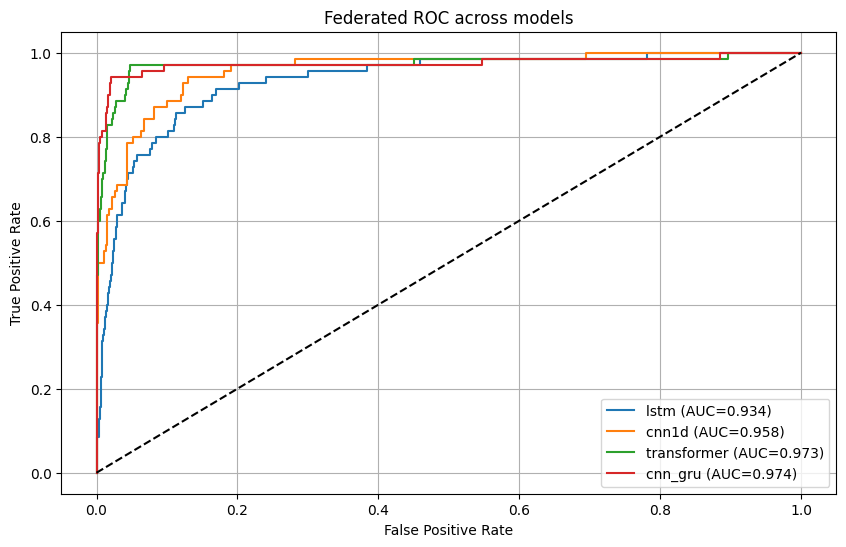

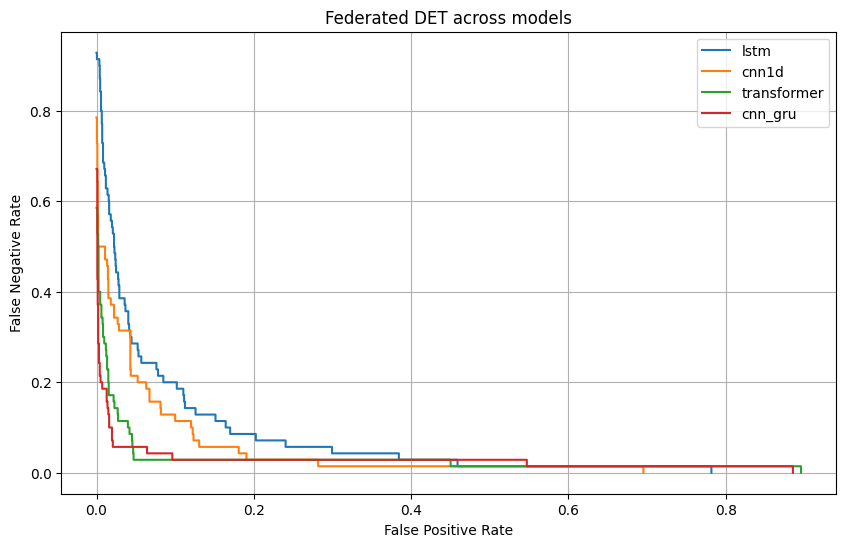

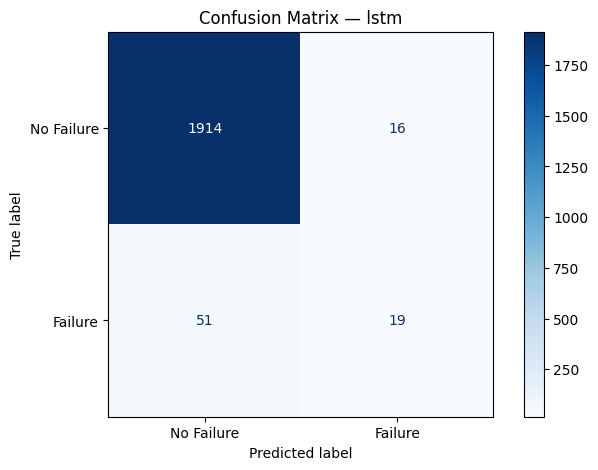

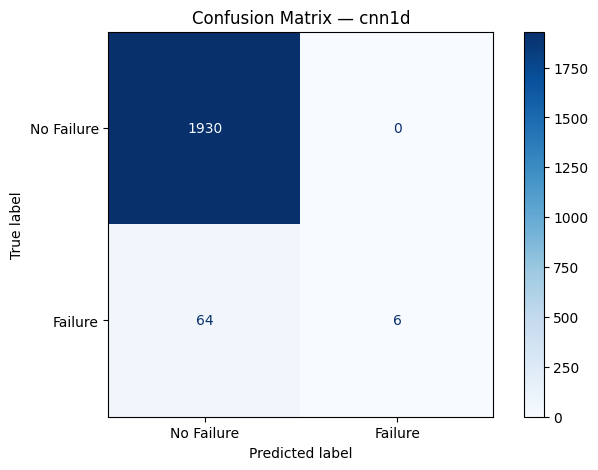

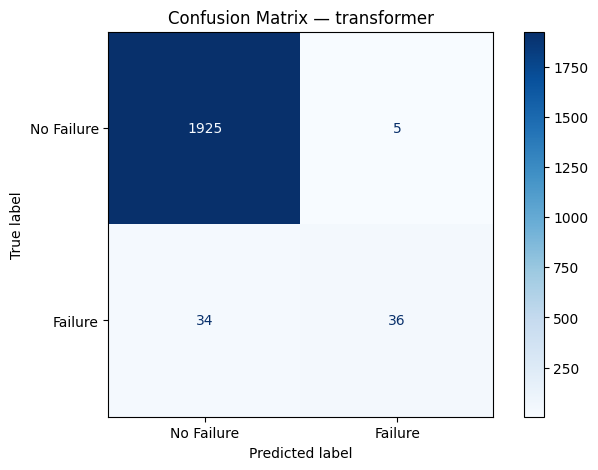

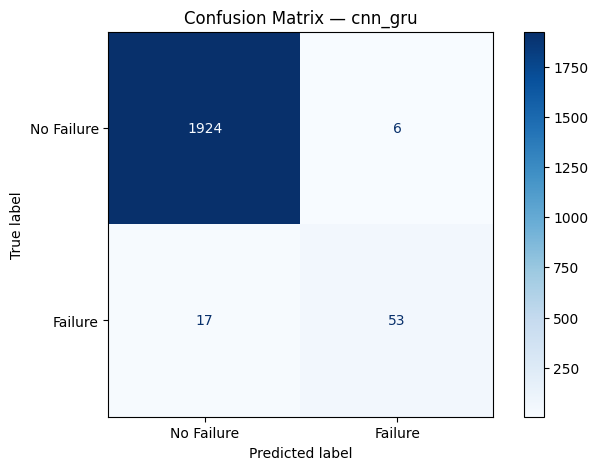

In [10]:
# ===== Federated simulation for all model kinds (FedAvg or FedProx) + evaluation & plots =====
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score, roc_auc_score,
    log_loss, matthews_corrcoef, cohen_kappa_score, confusion_matrix,
    roc_curve, det_curve, ConfusionMatrixDisplay
)

# ------------------ CONFIG ------------------
MODEL_KINDS = ["lstm", "cnn1d", "transformer", "cnn_gru"]  # run all
K = 3                              # number of clients
NUM_ROUNDS = 5                     # FL rounds
USE_FEDPROX = False                # True to enable FedProx
FEDPROX_MU  = 0.01                 # proximal coefficient (FedProx)

# per-client hyperparams (applied to every model; len must == K)
LOCAL_EPOCHS = [3, 3, 5]
LOCAL_BATCH  = [32, 64, 32]
LR_PER_CLIENT = [1e-3, 5e-4, 1e-3]

SAVE_WEIGHTS = False               # set True to save global weights per model & per round
# --------------------------------------------

assert len(LOCAL_EPOCHS)==K and len(LOCAL_BATCH)==K and len(LR_PER_CLIENT)==K, "Lengths must equal K"

# ===== helpers (FedAvg / FedProx) =====
def fedavg(we_list, n_list):
    total = np.sum(n_list)
    agg = []
    for layer_idx in range(len(we_list[0])):
        w = np.sum([we_list[c][layer_idx]*(n_list[c]/total) for c in range(len(we_list))], axis=0)
        agg.append(w)
    return agg

@tf.function
def train_step_fedprox(model, optimizer, x, y, global_weights, mu):
    with tf.GradientTape() as tape:
        y_pred = model(x, training=True)
        bce = tf.keras.losses.binary_crossentropy(y, y_pred)
        loss = tf.reduce_mean(bce)
        prox = tf.constant(0.0, dtype=tf.float32)
        for w, wg in zip(model.trainable_weights, global_weights):
            prox += tf.reduce_sum(tf.square(w - wg))
        loss += (mu/2.0)*prox
    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    return loss

def local_train(model, Xtr, ytr, Xva, yva, epochs, batch, lr, global_weights=None, mu=0.0, use_fedprox=False):
    opt = tf.keras.optimizers.Adam(lr)
    if not use_fedprox:
        model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])
        model.fit(Xtr, ytr, epochs=epochs, batch_size=batch, verbose=0, validation_data=(Xva, yva))
        return model.get_weights()
    else:
        ytr_ = ytr.astype("float32").reshape(-1,1) if ytr.ndim==1 else ytr.astype("float32")
        ds = tf.data.Dataset.from_tensor_slices((Xtr, ytr_)).batch(batch).prefetch(tf.data.AUTOTUNE)
        global_tensors = [tf.convert_to_tensor(g, dtype=w.dtype) for g, w in zip(global_weights, model.trainable_weights)]
        for _ in range(epochs):
            for xb, yb in ds:
                train_step_fedprox(model, opt, xb, yb, global_tensors, mu)
        return model.get_weights()

def build_model_by_kind(kind, in_obj):
    if kind == "mlp":          return build_mlp(in_obj)
    if kind == "lstm":         return build_lstm(in_obj)
    if kind == "cnn1d":        return build_cnn1d(in_obj)
    if kind == "transformer":  return build_transformer(in_obj)
    if kind == "cnn_gru":      return build_cnn_gru(in_obj)
    raise ValueError("Unknown model kind")

# ===== precompute stratified client splits once (shared across all model runs) =====
idx = np.arange(len(y_arr))
skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)
parts = [t for _, t in skf.split(idx, y_arr)]

# ===== store results here =====
all_summaries = []
roc_curves = {}  # name -> (fpr, tpr, auc)
det_curves = {}  # name -> (fpr, fnr)
conf_mats  = {}  # name -> confusion matrix (2x2)

# ===== run FL for each model kind =====
for model_kind in MODEL_KINDS:
    print(f"\n================= FL for {model_kind.upper()} =================")
    # choose representation
    if model_kind in ["mlp","transformer"]:
        X_all, in_obj = X_proc, input_dim
        X_eval = X_test_processed
    else:
        X_all, in_obj = X_seq,  input_shape
        X_eval = X_test_seq

    # init global model
    global_model = build_model_by_kind(model_kind, in_obj)
    global_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    global_weights = global_model.get_weights()

    # rounds
    for rnd in range(1, NUM_ROUNDS+1):
        client_weights, client_sizes = [], []
        for cid in range(K):
            # client data
            client_idx = parts[cid]
            Xc, yc = X_all[client_idx], y_arr[client_idx]
            Xtr, Xva, ytr, yva = train_test_split(Xc, yc, test_size=0.2, stratify=yc, random_state=42)

            # local model starts from current global
            local_model = build_model_by_kind(model_kind, in_obj)
            local_model.set_weights(global_weights)

            # local train
            w = local_train(
                local_model, Xtr, ytr, Xva, yva,
                epochs=LOCAL_EPOCHS[cid], batch=LOCAL_BATCH[cid], lr=LR_PER_CLIENT[cid],
                global_weights=global_weights, mu=FEDPROX_MU, use_fedprox=USE_FEDPROX
            )
            client_weights.append(w)
            client_sizes.append(len(Xtr))

        # aggregate
        global_weights = fedavg(client_weights, client_sizes)
        global_model.set_weights(global_weights)

        if SAVE_WEIGHTS:
            np.savez(f"global_{model_kind}_round_{rnd}.npz", *global_weights)
            print(f"[{model_kind}] saved global_{model_kind}_round_{rnd}.npz")

    # ===== evaluate final global model on held-out test =====
    y_proba = global_model.predict(X_eval, verbose=0).ravel()
    y_pred  = (y_proba >= 0.5).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    summary = {
        "Model": model_kind,
        "Accuracy": accuracy_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "Specificity": tn/(tn+fp) if (tn+fp)>0 else 0.0,
        "AUC": roc_auc_score(y_test, y_proba),
        "Log Loss": log_loss(y_test, y_proba),
        "MCC": matthews_corrcoef(y_test, y_pred),
        "Kappa": cohen_kappa_score(y_test, y_pred),
        "Miscls Err": (fp+fn)/(tp+tn+fp+fn)
    }
    all_summaries.append(summary)

    # curves & confusion matrix for plotting
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    fpr_det, fnr_det, _ = det_curve(y_test, y_proba)
    roc_curves[model_kind] = (fpr, tpr, summary["AUC"])
    det_curves[model_kind] = (fpr_det, fnr_det)
    conf_mats[model_kind]  = np.array([[tn, fp],[fn, tp]])

# ===== summary table =====
summary_df = pd.DataFrame(all_summaries).set_index("Model").round(4)
display(summary_df)

# ===== ROC plot across models =====
plt.figure(figsize=(10,6))
for mk, (fpr, tpr, aucv) in roc_curves.items():
    plt.plot(fpr, tpr, label=f"{mk} (AUC={aucv:.3f})")
plt.plot([0,1],[0,1],'k--')
plt.title("Federated ROC across models")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.grid(True); plt.legend(); plt.show()

# ===== DET plot across models =====
plt.figure(figsize=(10,6))
for mk, (fpr_det, fnr_det) in det_curves.items():
    plt.plot(fpr_det, fnr_det, label=mk)
plt.title("Federated DET across models")
plt.xlabel("False Positive Rate"); plt.ylabel("False Negative Rate")
plt.grid(True); plt.legend(); plt.show()

# ===== Confusion matrices per model =====
for mk, cm in conf_mats.items():
    disp = ConfusionMatrixDisplay(cm, display_labels=["No Failure","Failure"])
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix — {mk}")
    plt.grid(False)
    plt.show()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Best hybrid variant on validation AUC: CNN-BiGRU
Validation AUCs: {'LSTM': np.float64(0.963094467061436), 'HYB': np.float64(0.9627012398223538)}
Normalized ensemble weights: {'LSTM': np.float64(0.5001020947439224), 'HYB': np.float64(0.49989790525607763)}


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[Best Single] CNN-BiGRU {'Accuracy': 0.9905, 'F1': 0.8613, 'Precision': 0.8806, 'Recall': 0.8429, 'Specificity': np.float64(0.9959), 'AUC': np.float64(0.98), 'Log Loss': 0.0326, 'MCC': np.float64(0.8566), 'Kappa': np.float64(0.8564), 'Miscls Err': np.float64(0.0095)}
[Ensemble] Weighted Average {'Accuracy': 0.9905, 'F1': 0.8571, 'Precision': 0.9048, 'Recall': 0.8143, 'Specificity': np.float64(0.9969), 'AUC': np.float64(0.9799), 'Log Loss': 0.0349, 'MCC': np.float64(0.8535), 'Kappa': np.float64(0.8522), 'Miscls Err': np.float64(0.0095)}
[Ensemble] Stacked (LR meta) {'Accuracy': 0.9915, 'F1': 0.864, 'Precision': 0.9818, 'Recall': 0.7714, 'Specificity': np.float64(0.9995), 'AUC': np.float64(0.9797), 'Log Loss': 0.0377, 'MCC': np.float64(0.8663), 'Kappa': np.float64(0.8597), 'Miscls Err': np.float64(0.0085)}


,Accuracy,F1,Precision,Recall,Specificity,AUC,Log Loss,MCC,Kappa,Miscls Err
Model,,,,,,,,,,
Best Single (CNN-BiGRU),0.9905,0.8613,0.8806,0.8429,0.9959,0.9800,0.0326,0.8566,0.8564,0.0095
Ensemble (Weighted Avg),0.9905,0.8571,0.9048,0.8143,0.9969,0.9799,0.0349,0.8535,0.8522,0.0095
Ensemble (Stacked LR),0.9915,0.8640,0.9818,0.7714,0.9995,0.9797,0.0377,0.8663,0.8597,0.0085


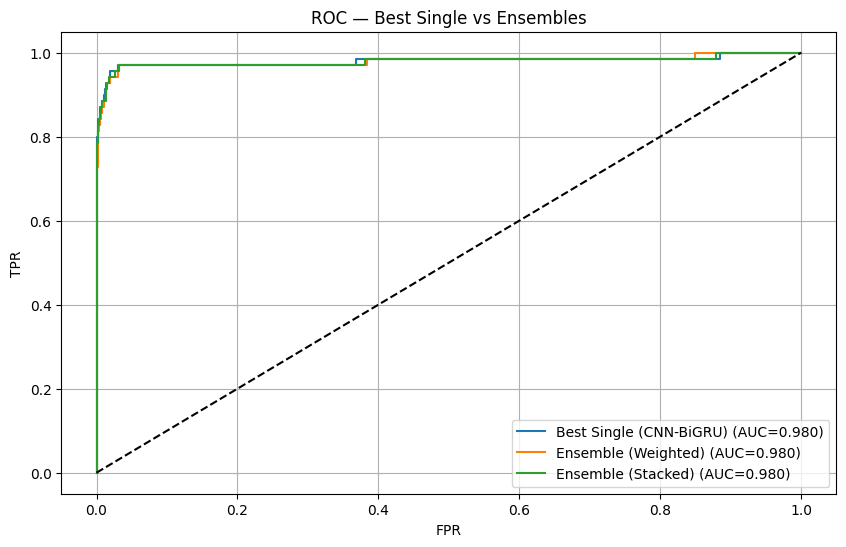

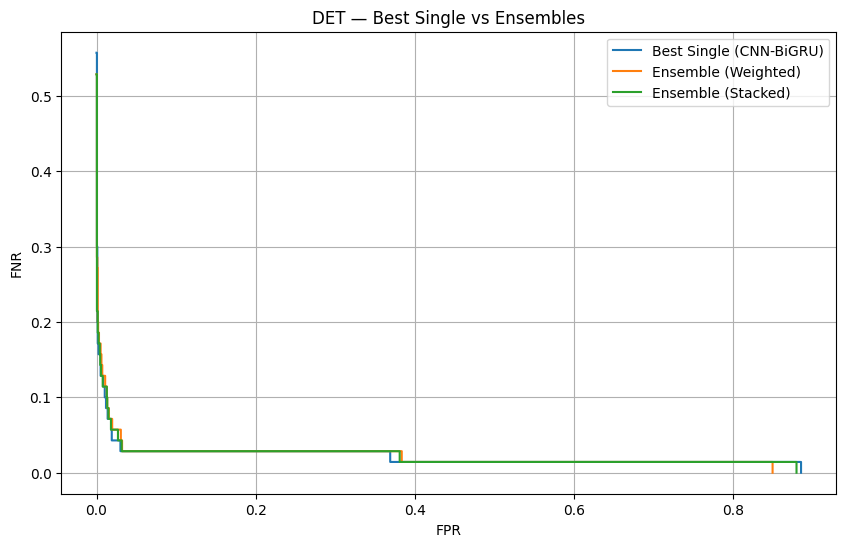

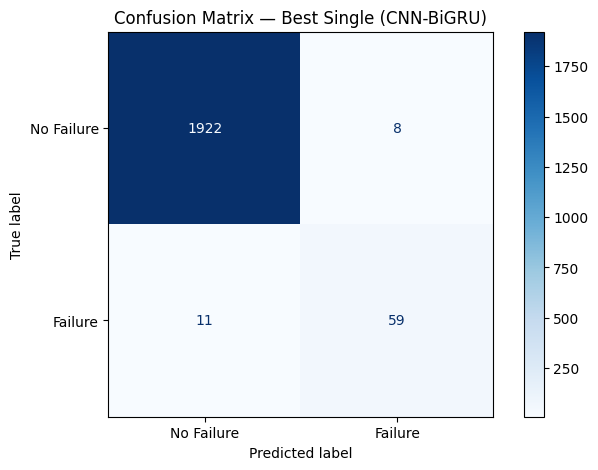

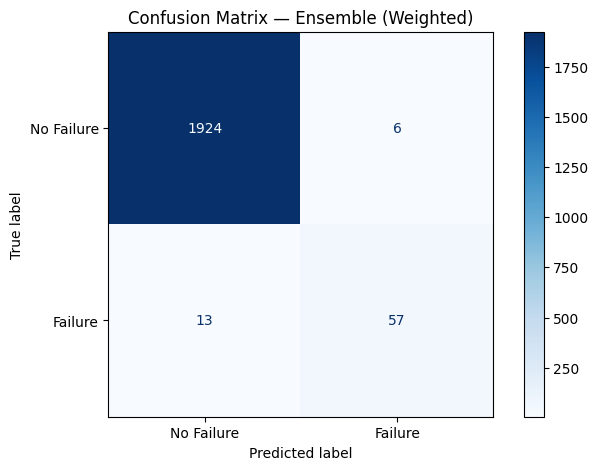

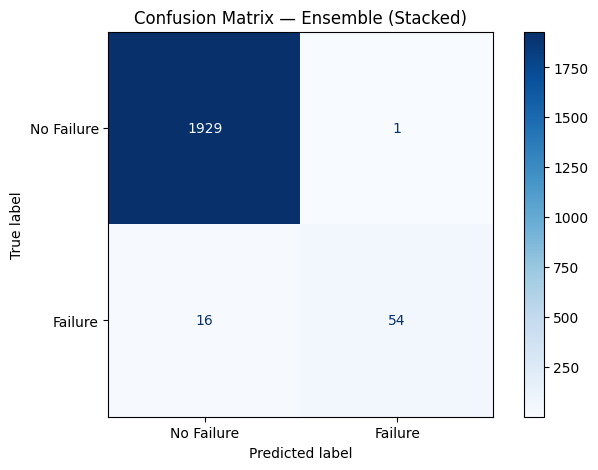

In [11]:
# ===== Make the ensemble the best: Weighted Average + Stacking (no leakage) =====
import numpy as np, pandas as pd, matplotlib.pyplot as plt, tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, log_loss,
    matthews_corrcoef, cohen_kappa_score, confusion_matrix, roc_curve, det_curve,
    ConfusionMatrixDisplay
)
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (Conv1D, MaxPooling1D, GRU, Bidirectional, LSTM,
                                     Dense, Dropout, Add, BatchNormalization, Input, Flatten)
from tensorflow.keras.callbacks import EarlyStopping

# ---------- CNN–GRU variant builders ----------
def build_cnn_gru_base(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv1D(64,3,activation='relu')(inputs); x = Dropout(0.3)(x)
    x = GRU(32)(x); x = Dropout(0.2)(x)
    out = Dense(1, activation='sigmoid')(x)
    return Model(inputs, out, name="CNN-GRU")

def build_cnn_bi_gru(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv1D(64,3,activation='relu')(inputs); x = Dropout(0.3)(x)
    x = Bidirectional(GRU(32))(x); x = Dropout(0.2)(x)
    out = Dense(1, activation='sigmoid')(x)
    return Model(inputs, out, name="CNN-BiGRU")

def build_deep_cnn_gru(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv1D(64,3,activation='relu')(inputs); x = BatchNormalization()(x)
    x = Conv1D(128,3,activation='relu')(x); x = MaxPooling1D(2)(x)
    x = Dropout(0.3)(x); x = GRU(32)(x); x = Dropout(0.2)(x)
    out = Dense(1, activation='sigmoid')(x)
    return Model(inputs, out, name="Deep-CNN-GRU")

def build_cnn_gru_residual(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv1D(64,3,activation='relu', padding='same')(inputs); x_skip = x
    x = Conv1D(64,3,activation='relu', padding='same')(x); x = Add()([x, x_skip])
    x = Dropout(0.3)(x); x = GRU(32)(x); x = Dropout(0.2)(x)
    out = Dense(1, activation='sigmoid')(x)
    return Model(inputs, out, name="CNN-GRU-Residual")

def build_cnn_gru_bottleneck(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv1D(64,3,activation='relu')(inputs); x = Dropout(0.3)(x)
    x = GRU(32)(x); x = Dropout(0.2)(x); x = Dense(32, activation='relu')(x)
    out = Dense(1, activation='sigmoid')(x)
    return Model(inputs, out, name="CNN-GRU-Bottleneck")

def compile_fit(model, Xtr, ytr, epochs=40):
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(Xtr, ytr, epochs=epochs, batch_size=32, validation_split=0.2,
              callbacks=[EarlyStopping(patience=6, restore_best_weights=True)], verbose=0)
    return model

def metrics_from_proba(y_true, proba, thr=0.5):
    pred = (proba >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, pred).ravel()
    return {
        "Accuracy": accuracy_score(y_true, pred),
        "F1": f1_score(y_true, pred),
        "Precision": precision_score(y_true, pred),
        "Recall": recall_score(y_true, pred),
        "Specificity": tn/(tn+fp) if (tn+fp)>0 else 0.0,
        "AUC": roc_auc_score(y_true, proba),
        "Log Loss": log_loss(y_true, proba),
        "MCC": matthews_corrcoef(y_true, pred),
        "Kappa": cohen_kappa_score(y_true, pred),
        "Miscls Err": (fp+fn)/(tp+tn+fp+fn)
    }, pred

# ---------- 1) Inner split to get validation predictions (for weights & stacker) ----------
from sklearn.model_selection import StratifiedShuffleSplit

# Ensure y_train is a NumPy array (no external indices)
y_train_arr = y_train.to_numpy() if hasattr(y_train, "to_numpy") else np.asarray(y_train)

# Make a stratified split on integer indices only
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
idx_tr, idx_val = next(sss.split(np.zeros(len(y_train_arr)), y_train_arr))

# Slice all views with the SAME indices to keep alignment
Xtr_seq  = X_train_seq[idx_tr]
Xval_seq = X_train_seq[idx_val]
Xtr_tab  = X_train_processed[idx_tr]
Xval_tab = X_train_processed[idx_val]
ytr      = y_train_arr[idx_tr]
yval     = y_train_arr[idx_val]


# Base models on inner-train
lstm_v = compile_fit(build_lstm(Xtr_seq.shape[1:]), Xtr_seq, ytr, epochs=35)

# Try all CNN–GRU variants on inner-train; pick best by AUC on val
variant_fns = {
    "CNN-GRU Baseline": build_cnn_gru_base,
    "CNN-BiGRU": build_cnn_bi_gru,
    "Deep-CNN-GRU": build_deep_cnn_gru,
    "CNN-GRU-Residual": build_cnn_gru_residual,
    "CNN-GRU-Bottleneck": build_cnn_gru_bottleneck,
}
val_auc = {}
variant_val_proba = {}
for name, fn in variant_fns.items():
    m = compile_fit(fn(Xtr_seq.shape[1:]), Xtr_seq, ytr, epochs=35)
    p = m.predict(Xval_seq, verbose=0).ravel()
    variant_val_proba[name] = p
    val_auc[name] = roc_auc_score(yval, p)

best_variant_name = max(val_auc, key=val_auc.get)
print("Best hybrid variant on validation AUC:", best_variant_name)

# Validation predictions for weights/stacker
lstm_val = lstm_v.predict(Xval_seq, verbose=0).ravel()
hyb_val  = variant_val_proba[best_variant_name]

# ---------- 2) Weighted average (weights from validation AUC, normalized) ----------
auc_scores = {
    "LSTM": roc_auc_score(yval, lstm_val),
    "HYB": roc_auc_score(yval, hyb_val),
}
w_sum = sum(auc_scores.values())
weights = {k: v / w_sum for k, v in auc_scores.items()}
print("Validation AUCs:", auc_scores)
print("Normalized ensemble weights:", weights)

# ---------- 3) Train meta-learner (stacking) on validation preds ----------
stack_X_val = np.column_stack([lstm_val, hyb_val])
meta = LogisticRegression(max_iter=1000)
meta.fit(stack_X_val, yval)

# ---------- 4) Refit base models on FULL training set for TEST inference ----------
lstm_f = compile_fit(build_lstm(X_train_seq.shape[1:]),      X_train_seq,      y_train, epochs=40)

# Refit the chosen best hybrid variant on FULL train set
hyb_builder = variant_fns[best_variant_name]
hyb_f = compile_fit(hyb_builder(X_train_seq.shape[1:]), X_train_seq, y_train, epochs=40)

# Test-set probabilities
lstm_p = lstm_f.predict(X_test_seq,       verbose=0).ravel()
hyb_p  = hyb_f.predict(X_test_seq,        verbose=0).ravel()

# Weighted average ensemble (test)
ens_weighted = (weights["LSTM"]*lstm_p + weights["HYB"]*hyb_p)

# Stacked ensemble (test) – use the same meta model trained on val
stack_X_test = np.column_stack([lstm_p, hyb_p])
ens_stacked = meta.predict_proba(stack_X_test)[:, 1]

# ---------- 5) Evaluate vs best single hybrid ----------
def eval_and_print(label, proba):
    metr, pred = metrics_from_proba(y_test, proba, thr=0.5)
    print(label, {k: round(v, 4) for k, v in metr.items()})
    return metr, pred

best_single_metr, best_single_pred = eval_and_print(f"[Best Single] {best_variant_name}", hyb_p)
wa_metr, wa_pred = eval_and_print("[Ensemble] Weighted Average", ens_weighted)
st_metr, st_pred = eval_and_print("[Ensemble] Stacked (LR meta)", ens_stacked)

# Summary table
summary = pd.DataFrame([
    {"Model": f"Best Single ({best_variant_name})", **best_single_metr},
    {"Model": "Ensemble (Weighted Avg)", **wa_metr},
    {"Model": "Ensemble (Stacked LR)", **st_metr},
]).set_index("Model").round(4)
display(summary)

# ---------- 6) Plots: ROC, DET, Confusion matrices ----------
def plot_roc(name, proba):
    fpr, tpr, _ = roc_curve(y_test, proba)
    aucv = roc_auc_score(y_test, proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={aucv:.3f})")

plt.figure(figsize=(10,6))
plot_roc(f"Best Single ({best_variant_name})", hyb_p)
plot_roc("Ensemble (Weighted)", ens_weighted)
plot_roc("Ensemble (Stacked)", ens_stacked)
plt.plot([0,1],[0,1],'k--'); plt.title("ROC — Best Single vs Ensembles")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.grid(True); plt.legend(); plt.show()

plt.figure(figsize=(10,6))
for name, proba in {
    f"Best Single ({best_variant_name})": hyb_p,
    "Ensemble (Weighted)": ens_weighted,
    "Ensemble (Stacked)": ens_stacked,
}.items():
    fpr_d, fnr_d, _ = det_curve(y_test, proba)
    plt.plot(fpr_d, fnr_d, label=name)
plt.title("DET — Best Single vs Ensembles"); plt.xlabel("FPR"); plt.ylabel("FNR")
plt.grid(True); plt.legend(); plt.show()

for name, pred in {
    f"Best Single ({best_variant_name})": (hyb_p>=0.5).astype(int),
    "Ensemble (Weighted)": (ens_weighted>=0.5).astype(int),
    "Ensemble (Stacked)": (ens_stacked>=0.5).astype(int),
}.items():
    cm = confusion_matrix(y_test, pred)
    ConfusionMatrixDisplay(cm, display_labels=["No Failure","Failure"]).plot(cmap="Blues")
    plt.title(f"Confusion Matrix — {name}"); plt.grid(False); plt.show()

In [12]:
# === BALANCED RL: Risk -> Env -> DQN + Training with returns/eps_history ===
import numpy as np
import tensorflow as tf
import gymnasium as gym
from gymnasium import spaces
from collections import deque
import random
from collections import deque as _deque

# ---------- 0) Risks & labels (use your best/federated model if available) ----------
if "risks" not in globals() or "labels" not in globals():
    try:
        risk_model = build_cnn_gru(input_shape)
    except Exception:
        from tensorflow.keras import Model, Input
        from tensorflow.keras.layers import Conv1D, GRU, Dropout, Dense
        def _build_cnn_gru(shape):
            inp = Input(shape=shape)
            x = Conv1D(64, 3, activation="relu")(inp); x = Dropout(0.3)(x)
            x = GRU(32)(x); x = Dropout(0.2)(x)
            out = Dense(1, activation="sigmoid")(x)
            return Model(inp, out)
        risk_model = _build_cnn_gru(X_seq.shape[1:])
    risk_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    try:
        risk_model.fit(X_seq, y_arr, epochs=3, batch_size=128, verbose=0)
    except Exception:
        pass
    risks  = risk_model.predict(X_seq, verbose=0).ravel().astype(np.float32)
    labels = (y_arr if isinstance(y_arr, np.ndarray) else np.asarray(y_arr)).astype(int)

# ---------- 1) Predictive Maintenance Env ----------
class PredictiveMaintenanceEnv(gym.Env):
    metadata = {"render_modes": []}
    def __init__(self, risks, labels, C_m=1.0, C_f=10.0, max_age=50, max_steps=None):
        super().__init__()
        self.risks = risks.astype(np.float32)
        self.labels = labels.astype(int)
        self.n = len(risks)
        self.C_m, self.C_f = C_m, C_f
        self.max_age = max_age
        self.max_steps = max_steps
        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Box(low=0.0, high=1.0, shape=(2,), dtype=np.float32)
        self.reset(seed=42)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.i, self.age, self.steps = 0, 0, 0
        obs = np.array([self.risks[self.i], 0.0], dtype=np.float32)
        return obs, {"label": int(self.labels[self.i])}

    def step(self, action):
        risk = self.risks[self.i]; label = int(self.labels[self.i])
        reward, terminated = 0.0, False
        if action == 1: reward -= self.C_m; self.age = 0
        else:
            self.age = min(self.age + 1, self.max_age)
            if label == 1: reward -= self.C_f; terminated = True
        self.i += 1; self.steps += 1
        if self.i >= self.n: terminated = True
        if self.max_steps is not None and self.steps >= self.max_steps: terminated = True
        obs = np.array([self.risks[min(self.i,self.n-1)], min(self.age/self.max_age,1.0)], dtype=np.float32)
        return obs, float(reward), terminated, False, {"label": int(self.labels[min(self.i,self.n-1)])}

# ---------- 2) DQN Agent ----------
class DQN:
    def __init__(self, state_dim=2, n_actions=2, lr=1e-3, gamma=0.99, buffer_size=15000, hidden=64, use_target=True):
        self.gamma = gamma; self.buffer = deque(maxlen=buffer_size); self.use_target=use_target
        self.model = tf.keras.Sequential([
            tf.keras.layers.Dense(hidden, activation='relu', input_shape=(state_dim,)),
            tf.keras.layers.Dense(hidden, activation='relu'),
            tf.keras.layers.Dense(n_actions, activation=None)
        ])
        self.model.compile(optimizer=tf.keras.optimizers.Adam(lr), loss='mse')
        if use_target:
            self.target_model = tf.keras.models.clone_model(self.model)
            self.target_model.set_weights(self.model.get_weights())

    def act(self, state, eps):
        if np.random.rand() < eps: return np.random.randint(self.model.output_shape[-1])
        q = self.model.predict(state[None,:], verbose=0)[0]; return int(np.argmax(q))
    def push(self,s,a,r,ns,d): self.buffer.append((np.asarray(s,np.float32),int(a),float(r),np.asarray(ns,np.float32),float(d)))
    def train_step(self, batch_size=64):
        if len(self.buffer)<batch_size: return
        batch = random.sample(self.buffer, batch_size)
        s=np.vstack([b[0] for b in batch]); a=np.array([b[1] for b in batch])
        r=np.array([b[2] for b in batch]); ns=np.vstack([b[3] for b in batch]); d=np.array([b[4] for b in batch])
        q=self.model.predict(s,verbose=0); qn=(self.target_model if self.use_target else self.model).predict(ns,verbose=0)
        td=r+(1-d)*self.gamma*np.max(qn,axis=1); target=q.copy(); target[np.arange(len(a)),a]=td
        self.model.train_on_batch(s,target)
    def hard_update_target(self):
        if self.use_target: self.target_model.set_weights(self.model.get_weights())

# ---------- 3) Training Loop ----------
NUM_EPISODES, MAX_STEPS_PER_EP = 60, 600
EPS_START, EPS_MIN, EPS_DECAY = 1.0,0.05,0.985
BATCH_SIZE, TRAIN_EVERY, TARGET_UPDATE_EVERY = 64,2,2
MA_WINDOW, PATIENCE = 8, 10

env = PredictiveMaintenanceEnv(risks, labels, C_m=1.0, C_f=10.0, max_age=50, max_steps=MAX_STEPS_PER_EP)
dqn = DQN()

epsilon=EPS_START; returns=[]; eps_history=[]; best_ma=-np.inf; recent=_deque(maxlen=MA_WINDOW); no_improve=0
for ep in range(NUM_EPISODES):
    s,_=env.reset(); done=False; ep_ret=0.0; step=0
    while not done:
        a=dqn.act(s,epsilon); ns,r,terminated,truncated,_=env.step(a); done=terminated or truncated
        dqn.push(s,a,r,ns,float(done));
        if step%TRAIN_EVERY==0: dqn.train_step(BATCH_SIZE)
        s=ns; ep_ret+=r; step+=1
    dqn.train_step(BATCH_SIZE)
    if (ep+1)%TARGET_UPDATE_EVERY==0: dqn.hard_update_target()
    epsilon=max(EPS_MIN,epsilon*EPS_DECAY); returns.append(ep_ret); eps_history.append(epsilon)
    recent.append(ep_ret); ma=float(np.mean(recent))
    if (ep+1)%5==0: print(f"Ep {ep+1}/{NUM_EPISODES} | Return={ep_ret:.1f} | MA={ma:.1f} | eps={epsilon:.2f}")
    if ep>=MA_WINDOW:
        if ma>best_ma+1e-3: best_ma=ma; no_improve=0
        else: no_improve+=1;
        if no_improve>=PATIENCE: print(f"Early stop at ep {ep+1}"); break



/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Ep 5/60 | Return=-36.0 | MA=-49.0 | eps=0.93
Ep 10/60 | Return=-30.0 | MA=-47.1 | eps=0.86
Ep 15/60 | Return=-28.0 | MA=-39.8 | eps=0.80
Ep 20/60 | Return=-19.0 | MA=-29.5 | eps=0.74
Ep 25/60 | Return=-26.0 | MA=-27.9 | eps=0.69
Ep 30/60 | Return=-37.0 | MA=-28.1 | eps=0.64
Ep 35/60 | Return=-32.0 | MA=-28.9 | eps=0.59
Ep 40/60 | Return=-22.0 | MA=-24.4 | eps=0.55
Ep 45/60 | Return=-23.0 | MA=-23.5 | eps=0.51
Ep 50/60 | Return=-22.0 | MA=-26.8 | eps=0.47
Early stop at ep 53


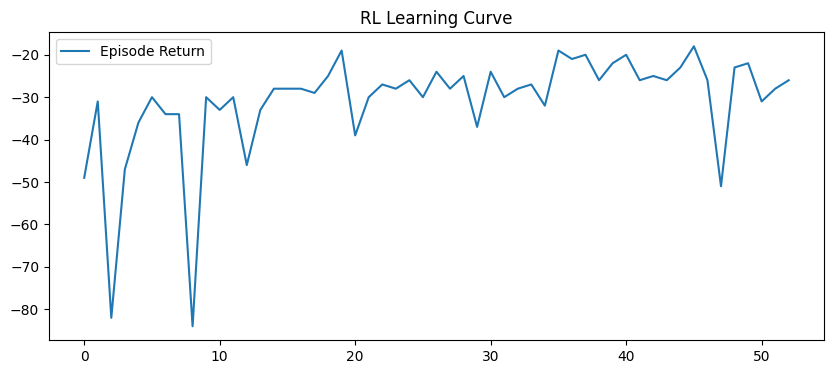

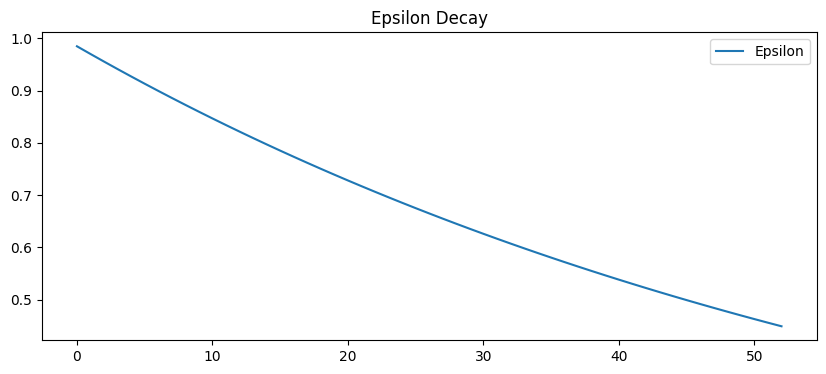

RL Policy Evaluation Metrics: {'Accuracy': 0.9804, 'F1': 0.0, 'Precision': 0.0, 'Recall': 0.0, 'AUC': np.float64(1.0)}


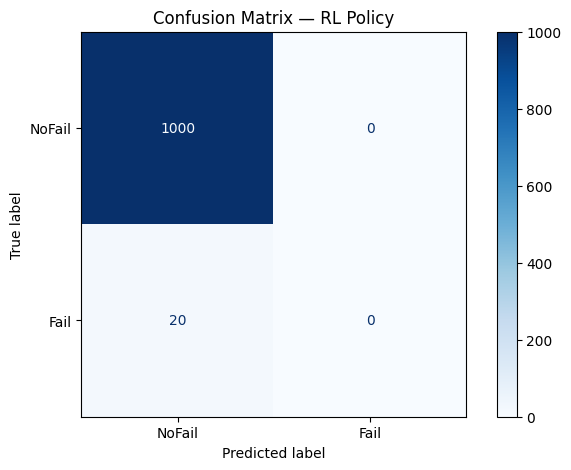

In [13]:
# ===== RL Evaluation: Return curves + classification metrics =====
import matplotlib.pyplot as plt, numpy as np
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,roc_auc_score,confusion_matrix,ConfusionMatrixDisplay

def _softmax(x): x=np.asarray(x); x=x-np.max(x); ex=np.exp(x); return ex/np.sum(ex)

# Curves
plt.figure(figsize=(10,4)); plt.plot(returns,label="Episode Return"); plt.title("RL Learning Curve"); plt.legend(); plt.show()
plt.figure(figsize=(10,4)); plt.plot(eps_history,label="Epsilon"); plt.title("Epsilon Decay"); plt.legend(); plt.show()

# Eval env
env_test = PredictiveMaintenanceEnv(risks, labels, C_m=1.0, C_f=10.0, max_age=50, max_steps=MAX_STEPS_PER_EP)
all_preds,all_probs,all_labels=[],[],[]

for _ in range(20):
    s,info=env_test.reset(); done=False
    while not done:
        q=dqn.model.predict(s[None,:],verbose=0)[0]; a=int(np.argmax(q)); prob=float(_softmax(q)[a])
        ns,r,terminated,truncated,info=env_test.step(a); done=terminated or truncated
        all_preds.append(a); all_probs.append(prob); all_labels.append(int(info.get("label", int(r>0)))); s=ns

all_preds,all_probs,all_labels=np.array(all_preds),np.array(all_probs),np.array(all_labels)
metrics={"Accuracy":accuracy_score(all_labels,all_preds),"F1":f1_score(all_labels,all_preds,zero_division=0),
         "Precision":precision_score(all_labels,all_preds,zero_division=0),"Recall":recall_score(all_labels,all_preds,zero_division=0)}
try: metrics["AUC"]=roc_auc_score(all_labels,all_probs)
except: metrics["AUC"]=float("nan")
print("RL Policy Evaluation Metrics:",{k:round(v,4) if np.isfinite(v) else v for k,v in metrics.items()})
cm=confusion_matrix(all_labels,all_preds,labels=[0,1]); ConfusionMatrixDisplay(cm,display_labels=["NoFail","Fail"]).plot(cmap="Blues")
plt.title("Confusion Matrix — RL Policy"); plt.show()
